# Introducción

Una nueva comunidad vanguardista para los aficionados de las películas clásicas está desarrollando un sistema para filtrar y categorizar reseñas de películas en positivas y negativas de manera automática.

# Objetivo del proyecto

Mediante las reseñas de películas y de otros productos similares se debe crear un modelo para detectar las críticas negativas y positivas de forma automática con una métrica f1 de al menos 0.85.

## Inicialización

Cargar las librerías necesarias para la ejecución del proyecto.

In [13]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import spacy
from lightgbm import LGBMClassifier


from tqdm.auto import tqdm

# Métrica de evaluación f1

from sklearn.metrics import f1_score

# Eliminar todos los caracteres exepto letras, apostrofos y espacios
import re

# Para crear una bolsa de palabras
from collections import Counter

# Vecotorizar mediante nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Librería para el Modelo 0
from sklearn.dummy import DummyClassifier

# Importar las librerías necesarias para Modelo1
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Librería de vectorización
from sklearn.feature_extraction.text import TfidfVectorizer

# Importador de las palabras vacías.
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")

#Librería para la regresión logística
from sklearn.linear_model import LogisticRegression


# Para eliminar las palabras vacías al momento de hacer una bolsa de palabras
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords") # importar correctamente la función de palabras vacías.
# Para hacer una bolsa de palabras con n-gramas
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

In [15]:
# esto es para usar progress_apply
tqdm.pandas()

## Cargar datos

In [16]:
# Cargar los datos necesarios
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Descripción general de los datos

In [17]:
# Primeras filas
df_reviews.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489


In [18]:
# Valores únicos de columnas title_type
df_reviews['title_type'].unique()

array(['movie', 'short', 'tvEpisode', 'video', 'tvMovie', 'tvSpecial',
       'tvSeries', 'tvMiniSeries', 'videoGame', 'tvShort'], dtype=object)

In [19]:
# Características de las filas
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [20]:
# Distribución de los valores numéricos.
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [21]:
# Presencia de duplicados
df_reviews.duplicated().sum()

0

In [22]:
# Presencia de valores ausentes
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

La compañía no ofrece una descripción previa de las columnas, pero por lo observado previamente pueden intuirse los siguientes significados:

- `tconst`: identificador único de la grabación. Puede haber diversas reseñas por una misma pieza.
- `title_type`: tipo de grabación. Incluye películas, cortos, series, miniseries y videojuegos en distintos formatos.
- `primary_title`: podría ser el nombre comercial de la pieza.
- `original_title`: nombre original de la pieza.
- `start_year`: se presume, es el día en que se estrenó la película.
- `end_year`: podría ser el año en que se dejaron de emitir reseñas.
- `runtime_minutes`: tiempo que dura la grabación.
- `is_adult`:
- `genres`: género(s).
- `average_rating`: puntaje de evaluación promedio.
- `votes`: número de votos recibidos por la pieza.
- `review`: una de las reseñas.
- `rating`: puntaje dado por la eprsona que creó la reseña.
- `sp`: si la reseña fue positiva o negativa, en letras.
- `pos`: si la reseña fue positiva [1] o negativa [0].
- `ds_part`: si esta fila será parte del conjunto de entrenameinto o del conjunto de prueba.
- `idx`: identificador único de la reseña.

**Observaciones:**

- Dado que no sólo tenemos datos de películas sino de cortos y hasta videojuegos, nos referiremos a todos los materiales con el término genérico de grabaciones o de piezas.
- Cada fila representa una reseña distinta, no obtsante, puede haber varias reseñas de una misma grabación. En ese caso, todos los valores se repiten, exeptuando, por supuesto, `review`, además de el valor de la columna `rating`, `idx` y posiblemente `ds_part`. 
- La mayoría de las columnas no son necesarias para el objetivo del proyecto pero pueden ser exploradas para observar algunas de las características de la base de datos además de dar contexto a las reseñas.
- Los datos estan completos (excepto por una cantidad despreciable de valores ausentes), sin valores duplicados, algunos tipos de valores podrían tener un tipo más adecuado pero no será necesario modificarlos puesto que sus filas serán eliminadas.
- La columna `review` es definitivamente la más útil. Cabe la posibilidad de utilizar `rating` como imput pues es de esperarse que entre mayor sea su puntaje, la reseña ha de tener una mayor probabilidad de ser positiva. No obstante, queda fuera del objetivo por lo que deberá descartarse finalmente.

## EDA

Primero, podemos revisar el número de reseñas tanto positivas como negativas de las grabaciones. 

In [23]:
df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()[0] + df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()[1]

start_year
1894       6.0
1895       NaN
1897       NaN
1902       NaN
1903      10.0
         ...  
2006    3275.0
2007    2106.0
2008     991.0
2009     386.0
2010       NaN
Length: 107, dtype: float64

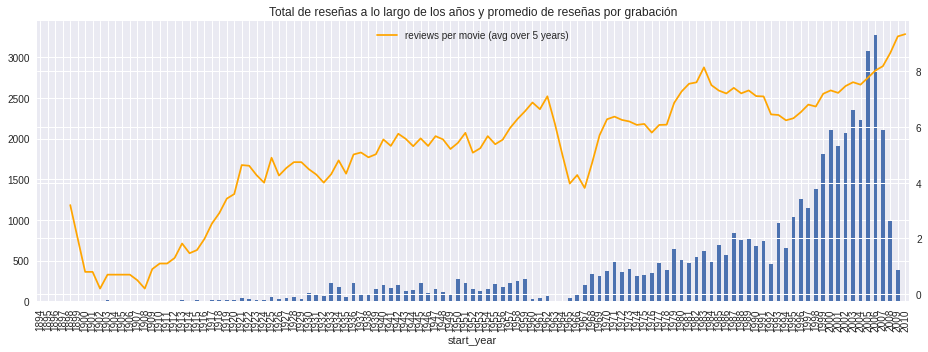

In [24]:
fig, axs = plt.subplots()

#Econntrar el número de grabaciones únicas por año.
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
# Recoloar un índice con valores desde el primer año en que se hizo una película hasta 2021 y rellenar los ausentes con 0
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), dft1.index.max()+1)).fillna(0)
# Obtener una tabla de cuántas reseñas positivas y negativas ha habido por año.
#dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()[0] + df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()[1]

# Reindexar con todos los años y colocar cero en los valores ausentes.
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), dft2.index.max()+1)).fillna(0)

#Graficar
dft2.plot(kind='bar', stacked=True, ax=axs, figsize=(13,5))

# Obtener el total de reseñas por año y rellenar sus valores ausentes con cero.
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), dft2.index.max()+1)).fillna(0)

# Dividir el total de reseñas entre el número de grabaciones. Eso resulta en las reseñas por grabación.
dft3 = (dft2/dft1).fillna(0)
axt = axs.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
axs.legend(lines, labels, loc='upper center')

axs.set_title('Total de reseñas a lo largo de los años y promedio de reseñas por grabación')

fig.tight_layout()

**Observaciones:**

- Antes de 1969, el número de reseñas era muy reducido. Multiples causas podrían explicar esto. Pudo haber sido por un bajo número de productos y un bajo número de personas conectadas a foros de discusión o que simplemente no se hayan tomado en cuenta todas las reseñas de los valores más antiguos.
- A pesar de lo anterior, el número promedio de reseñas por grabación no es tan bajo. Ello se debe al reducido número de grabaciones para el mismo periodo.
- A partir de la década de 1990 el registro de reseñas en términos absolutos comienza a crecer rápidamente con una posterior caída en el 2008.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

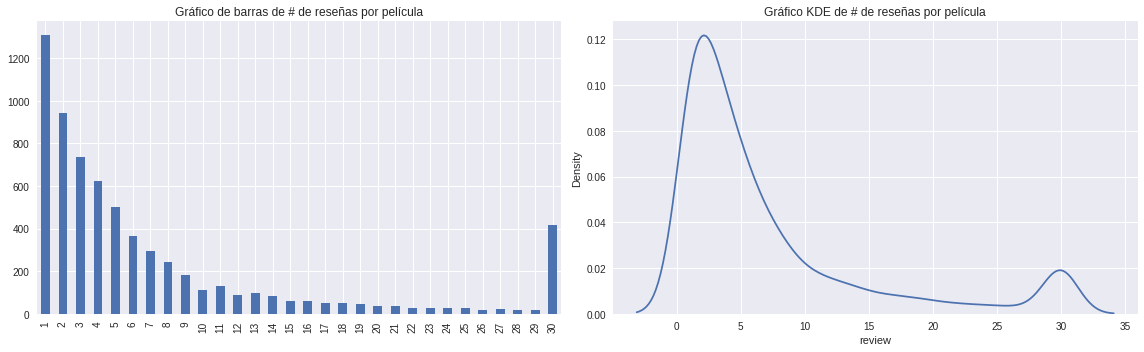

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))


dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=axs[0])
axs[0].set_title('Gráfico de barras de # de reseñas por película')


dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=axs[1])
axs[1].set_title('Gráfico KDE de # de reseñas por película')

fig.tight_layout()

**Observaciones:**

- El número de películas con una sola reseña es muy elevado. Hay pocas grabaciones con más de 10 reseñas en nuestra base de datos. Sin embargo, y contrario a lo que se esperaría observando el patrón del gráfico, hay un considerable número de gravaciones con treinta reseñas. 

In [26]:
df_reviews['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

**Observación:**

- El número de reseñas positivas es ligeramente menor al número de reseñas negativas. Por lo tanto, no hay desequilibrio de clases.

A continuación, se visualizan las distirbuciones de las calificaciones por cada reseña realizada dividida entre conjunto de entrenamiento y conjunto de prueba.

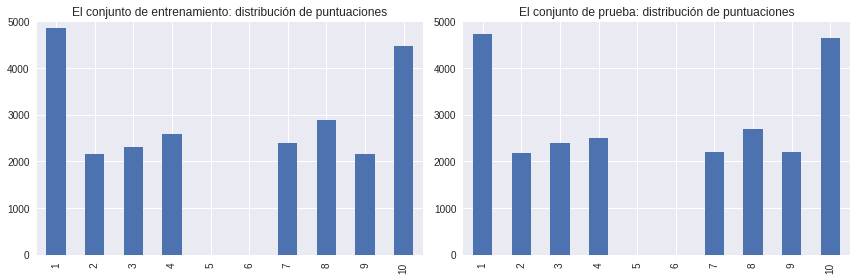

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

**Observaciones:**

- La distribución de ambos tipos de reseñas es extremadamente similar.
- Dado que no hay puntuaciones entre 5 y 6 es muy tentador establecer esta brecha como un diferenciador claro entre lo que se considera como una buena reseña (menor a 5) y lo que se considera como una buena reseña (mayor a 6).

In [28]:
# Número de reseñas positivas y negativas por debajo de una calificación de 5
df_reviews.query("rating < 5")['pos'].value_counts()

0    23715
Name: pos, dtype: int64

In [29]:
# Número de reseñas positivas y negativas por encima de una calificación de 6.
df_reviews.query("rating > 6")['pos'].value_counts()

1    23616
Name: pos, dtype: int64

In [30]:
# Reseñas totales
df_reviews.shape

(47331, 17)

In [31]:
# Suma de las reseñas positivas y negativas.
23715 + 23616

47331

**Observaciones:**

- Claramente, todas las calificaciones con valores menores a 5 corresponen a reseñas negativas; las calificaciones mayores a 6, a positivas. Esta podría ser una variable decisiva en el modelo que mejore ampliamente sus métricas. No obstante, como el objetivo es realizar una interpretación de reseñas, no se integrará en los modelos posteriores pero debe dejarse como un indicador que podría ser clave si se integrase.

A continuación, se deben visualizar las distribuciones de las reseñas positivas y negativas en cada conjunto de datos con el fin de ver su similaridad y su proporción.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


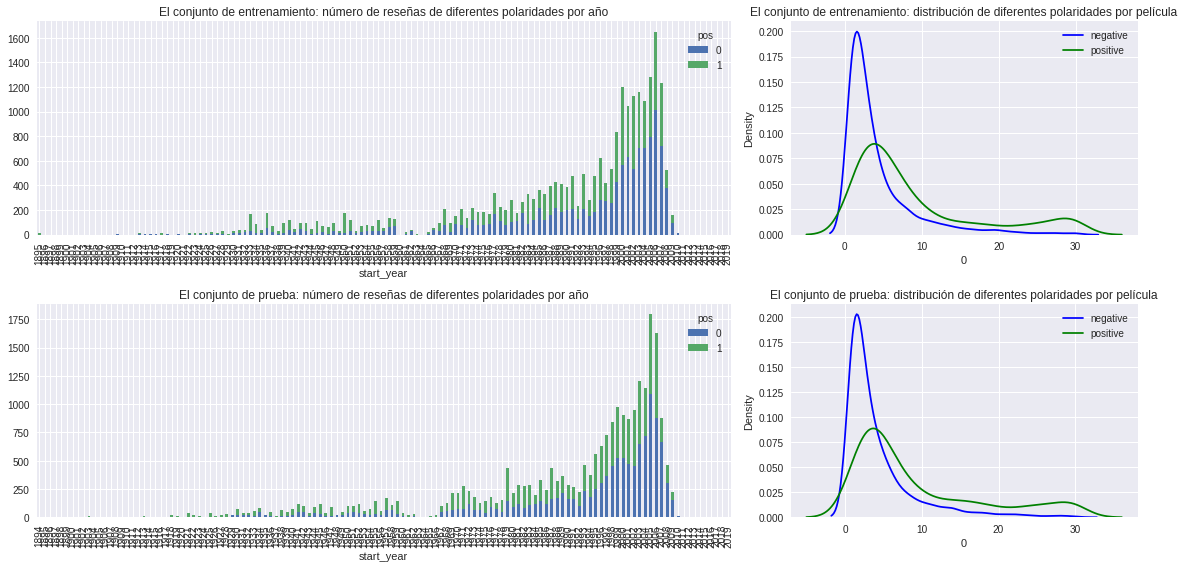

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative',  ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

**Observaciones:**

- Como sugerían las gráficas anteriores, las distribuciones del conjunto de entrenamiento y prueba son muy similares. Tanto a lo largo de los años como entre reseñas positivas y negativas.
- Los gráficos de KDE sugieren que hay pocas grabaciones con muchas reseñas. Esto indica que las reseñas se concentran en pocas grabaciones "famosas" mientras que hay muchos productos que terminan con pocos comentarios.

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc. Para ello se urarán expresiones regulares.

In [33]:
# eliminar todos los carcateres excepto letras, apostrofos y espacios.
clean_text = []

for texto in df_reviews["review"]:
    pattern = r"[^a-zA-Z']"
    # Sustituir cada texto por otra versión
    texto = re.sub(pattern, " ", texto)
    # Dividirá el texto tomando los espacios como separación y creará una lista
    texto = texto.split()
    #Unirá los elementos de la lista mediante un espacio creando un solo texto
    texto = " ".join(texto)
    # Poner el texto todo en minúsculas
    texto = texto.lower()
    # Devolver el texto a una lista
    clean_text.append(texto)
    
#Agregar la lista a la base de datos
df_reviews['cleaned_review'] = pd.Series(clean_text)

In [34]:
df_reviews.head(2)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,cleaned_review
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...


## División entrenamiento / prueba

La columna `ds_part` sugiere una forma de dividir los conjuntos de datos de entrenamiento y prueba. Es aceptable ya que, como se ha visto, las distribuciones de ambos conjuntos son muy similares. Siguiendo el tenor del objetivo, seleccionaremos sólo la columna `cleaned_review`.

In [35]:
# Características para el conjunto de prueba y entrenamiento 
x_train = df_reviews.query('ds_part == "train"')["cleaned_review"].copy()
x_test = df_reviews.query('ds_part == "test"')["cleaned_review"].copy()

# Objetivos para el conjunto de prueba y entrenamiento
y_train = df_reviews.query('ds_part == "train"')['pos'].copy()
y_test = df_reviews.query('ds_part == "test"')['pos'].copy()

# Dimensiones de cada conjunto de datos
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(23796,)
(23535,)
(23796,)
(23535,)


In [36]:
# Comprobar valores de los objetivos del conjunto de entrenamiento.
y_train.head()

0    0
1    0
7    0
8    0
9    0
Name: pos, dtype: int64

In [37]:
# Comprobar valores de las características del conjunto de entrenamiento.
x_train.head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
7    this true story of carlson's raiders is more o...
8    should have been titled 'balderdash ' little i...
9    the movie 'gung ho ' the story of carlson's ma...
Name: cleaned_review, dtype: object

## Trabajar con modelos

Se probarán cuatro modelos distintos para realizar las predicciones:

- Modelo 0: un modelo dummy que servirá como prueba de cordura o base mínima de rendimiento de los demás modelos.
- Modelo 1: el preprocesamiento de los textos se realizará con NLTK, la vectorización con td_idf y un modelo de regresión logística para las predicciones.
- Modelo 2: preprocesamiento con Spacy, vectorización con tf_idf y predicciones con regresión logística.
- Modelo 3: preprocesamiento con Spacy, vecotrización con tf_idf y predicciones con LGBM. 

### Modelo 0 - Constante

In [38]:
# Crear instancias del modelo
dummy = DummyClassifier(strategy="uniform", random_state=24601)
# Entrenar el modelo
dummy.fit(x_train, y_train)
# Predicciones
dummy_omens = dummy.predict(x_test)
# Evaluación del modelo
dummy_f1 = f1_score(y_test, dummy_omens)
#Resultado de evaluación
dummy_f1

0.4988255391842836

### Modelo 1 - NLTK, TF-IDF y LR

Crear una lista de palabras vacías

In [39]:
# Crear una lista de palabras vacías del inglés.
stop_words = set(stopwords.words('english'))

# Crear instancia para lematizar
lemmatizer = WordNetLemmatizer()

# Función para de preprocesamiento para cada texto del conjunto de datos

def text_preprocessing_2(df):
    preprocesado = []
    
    for text in df:
        # Obtener los tokens del texto
        tokens = word_tokenize(text.lower())
        # Por cada lista de tokens devolverá una lista lematizada
        lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        # El proceso anterior devuelve una lista de lemmas y necesitamos un solo lema, lo unimos con lo siguiente
        lista = " ".join(lemmas)
        # Agregamos el resultado a una lista para después convertirlo en un objeto series
        preprocesado.append(lista)
        
    preprocesado = pd.Series(preprocesado)    
    
    return preprocesado 

In [40]:
# Tokenizar y lematizar conjutno de entrenamiento y prueba. M1 es para modelo 1, m2 para modelo 2 y así sucesivamente 
m1x_train = text_preprocessing_2(x_train) # textos preprocesados del conjunto de entrenamiento
m1x_test = text_preprocessing_2(x_test) # textos preprocesados del conjunto de prueba
m1x_train # Visualizar

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        this true story of carlson 's raider is more o...
3        should have been titled 'balderdash ' little i...
4        the movie 'gung ho ' the story of carlson 's m...
                               ...                        
23791    o my gosh just give me a minute to breath this...
23792    i ca n't tell you all how much i love this mov...
23793    legend of zu is possibly the most exciting mov...
23794    this movie is well done on so many level that ...
23795    a a history nut who is particularly interested...
Length: 23796, dtype: object

Vectorización de los textos preprocesados con TF-IDF

In [41]:
# Crear un modelo con tf-idf
count_tf_idf = TfidfVectorizer(stop_words = stop_words, ngram_range=(1,1))
# Ajustar y transformar conjunto de entrenamiento para obtener características conjunto de entrenamiento 
tf_idf = count_tf_idf.fit_transform(m1x_train)
# Características conjunto de prueba
tf_idf_test = count_tf_idf.transform(m1x_test)

Implementación de la regresión logística.

In [42]:
# Crear instacia del modelo de regresión logística
m1_logistic = LogisticRegression(random_state = 24601, max_iter=200, penalty = "l2")
# Entrenar el modelo con el conjunto de entrenamiento
m1_logistic.fit(tf_idf, y_train)
# Predicciones
m1_omens = m1_logistic.predict(tf_idf_test)
# Evaluar el modelo
m1_f1 = f1_score(y_test, m1_omens)
# Resultados
m1_f1

0.8794132696571721

### Modelo 3 - spaCy, TF-IDF y LR

In [43]:
#Cargar la instancia desde spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Preprocesamiento de los textos con spaCy:

In [44]:
# Definir función de preprocesamiento
def text_preprocessing_3(df):
    
    preprocesado = []
    for text in df:
        
        doc = nlp(text)
        
        lemmas = [token.lemma_ for token in doc] #tokens = [token.lemma_ for token in doc if not token.is_stop]
        
        lemmas = " ".join(lemmas)
        
        preprocesado.append(lemmas)
        
    preprocesado = pd.Series(preprocesado)
    
    return preprocesado

In [45]:
%%time
# Aplicación de la función
m2x_train = text_preprocessing_3(x_train)
m2x_train

CPU times: user 8min 40s, sys: 179 ms, total: 8min 40s
Wall time: 8min 49s


0        the pakage imply that warren beatty and goldie...
1        how the hell do they get this make present its...
2        this true story of carlson 's raider be more o...
3        should have be title ' balderdash ' little in ...
4        the movie ' gung ho ' the story of carlson 's ...
                               ...                        
23791    o my gosh just give I a minute to breath this ...
23792    I can not tell you all how much I love this mo...
23793    legend of zu be possibly the most exciting mov...
23794    this movie be well do on so many level that I ...
23795    as a history nut who be particularly intereste...
Length: 23796, dtype: object

In [46]:
m2x_test = text_preprocessing_3(x_test)
m2x_train

0        the pakage imply that warren beatty and goldie...
1        how the hell do they get this make present its...
2        this true story of carlson 's raider be more o...
3        should have be title ' balderdash ' little in ...
4        the movie ' gung ho ' the story of carlson 's ...
                               ...                        
23791    o my gosh just give I a minute to breath this ...
23792    I can not tell you all how much I love this mo...
23793    legend of zu be possibly the most exciting mov...
23794    this movie be well do on so many level that I ...
23795    as a history nut who be particularly intereste...
Length: 23796, dtype: object

Vectorización de los textos con TF-IDF:

In [47]:
# Crear segundo modelo con tf-idf 
count_tf_idf_2 = TfidfVectorizer(stop_words = stop_words, ngram_range=(1,1))
# Ajustar y transformar conjunto de entrenamiento para obtener características conjunto de entrenamiento 
tf_idf_2 = count_tf_idf_2.fit_transform(m2x_train)
# Vectorización del conjutno de entrenamiento.
tf_idf_test_2 = count_tf_idf_2.transform(m2x_test) # Características del conjunto de entrenamiento.

Implementación del modelo de regresión logística:

In [48]:
# Crear instacia del modelo de regresión logística
m2_logistic = LogisticRegression(random_state = 24601)
# Entrenar el modelo con el conjunto de entrenamiento
m2_logistic.fit(tf_idf_2, y_train)
# Hacer predicciones
m2_omens = m2_logistic.predict(tf_idf_test_2)
# Calcular la métrica f1
m2_f1 = f1_score(y_test, m2_omens)
#Resultados
m2_f1

0.8788380685437636

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

Tanto el preprocesamiento como la vecotrización ya fueron realizadas dentro del modelo anterior, por lo que aquí simplemente se aplica un modelo disntinto para las predicciones.

In [49]:
# Instancia
m3_lgbm = LGBMClassifier(random_state=24601, learning_rate = 0.05, n_estimators = 100, objective = "binary", num_leaves = 60)
# Entrenamiento
m3_lgbm.fit(tf_idf_2, y_train)
# Predicciones
m3_omens = m3_lgbm.predict(tf_idf_test_2)
# Evaluación
m3_f1 = f1_score(y_test, m3_omens)
#Resultado
m3_f1

0.844273062417899

## Mis reseñas

Para comparar los distintos valores de clasificación que arrojan nuestros modelos podemos pasarle las siguientes reseñas y comparar sus resultados.

In [50]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# eliminar todos los carcateres excepto letras, apostrofos y espacios.
clean_text = []

for texto in my_reviews["review"]:
    pattern = r"[^a-zA-Z']"
    # Sustituir cada texto por otra versión
    texto = re.sub(pattern, " ", texto)
    # Dividirá el texto tomando los espacios como separación y creará una lista
    texto = texto.split()
    #Unirá los elementos de la lista mediante un espacio creando un solo texto
    texto = " ".join(texto)
    # Poner el texto todo en minúsculas
    texto = texto.lower()
    # Devolver el texto a una lista
    clean_text.append(texto)
    
#Agregar la lista a la base de datos
my_reviews['review_norm'] = pd.Series(clean_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 2

In [51]:
texts = my_reviews['review_norm']
cleaned_text = text_preprocessing_2(texts)

my_reviews_pred_prob = m1_logistic.predict_proba(count_tf_idf.transform(cleaned_text))[:, 1]

for i, review in enumerate(cleaned_text.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.14:  well i wa bored and felt asleep in the middle of the movie
0.46:  i wa really fascinated with the movie
0.12:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.30:  i did n't expect the reboot to be so good writer really cared about the source material
0.53:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.87:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


### Modelo 3

In [52]:
# Tokenizar y lematizar las reseñas propias para el modelo 3
cleaned_text = text_preprocessing_3(texts)


my_reviews_pred_prob = m2_logistic.predict_proba(count_tf_idf_2.transform(cleaned_text))[:, 1]

for i, review in enumerate(cleaned_text.str.slice(0, 110)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  I do not simply like it not my kind of movie
0.12:  well I be bored and feel asleep in the middle of the movie
0.49:  I be really fascinated with the movie
0.10:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab
0.27:  I do not expect the reboot to be so good writer really care about the source material
0.50:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to s
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like
0.92:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciti


### Modelo 4

In [53]:
tfidf_vectorizer_4 = count_tf_idf_2
my_reviews_pred_prob = m3_lgbm.predict_proba(count_tf_idf_2.transform(cleaned_text))[:, 1]

for i, review in enumerate(cleaned_text.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  I do not simply like it not my kind of movie
0.39:  well I be bored and feel asleep in the middle of the movie
0.63:  I be really fascinated with the movie
0.37:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.74:  I do not expect the reboot to be so good writer really care about the source material
0.75:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.25:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.75:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


**Observaciones:**

Ambos modelos de regresión logística funcionan relativamente bien. Las probabilidades de clasificación son distintas para cada reseña, y en la mayoría de los casos el tono de la reseña coincide con su probabilidad. Recordemos que con una probabilidad menor del 0.5 la reseña se considera como negativa; mayor a 0.5, positiva. En el caso del modelo LGBM ocurre que las probabilidades para distintas reseñas son exactamente iguales. Eso debe indicar algún problema con el modelo que también se refleja en el bajo valor de su métrica f1 en comparación con sus homólogos de regresión logística. 

## Resumen de los resultados

Crearemos una tabla que permita comparar los resultados obtenidos:

In [54]:
data = [0.85,
        dummy_f1,
          m1_f1,
          m2_f1,
          m3_f1]
index = ["Valor mínimo f1",
         "M. dummy",
        "M. NLK TF-IDF LR",
        "M. spaCy TF-IDF LR",
        "M. spaCy TF-IDF LGBM"]

resumen = pd.DataFrame(index = index, data = data, columns = ["Métrica F1"]).round(4)

resumen

,Métrica F1
Valor mínimo f1,0.8500
M. dummy,0.4988
M. NLK TF-IDF LR,0.8794
M. spaCy TF-IDF LR,0.8788
M. spaCy TF-IDF LGBM,0.8443


Como era de esperarse, dada la situación casi simétrica de los valores objetivo, el modelo dummy alcanza un valor de f1 muy bajo del 0.49. EN cambio, los modelos de regresión logística cuyos textos fueron entrenados con spaCy o NLTK sobrepasaron el valor mínimo de 0.85. Curiosamente, el modelo LGBM no, si bien estuvo muy cerca del valor mínimo.

## Conclusiones

Se exploraron los valores de todo el marco de datos original. En un principio se contaba con un amplio número de columnas con diversos valores que fueron explorados para entender la naturaleza de los datos y el contexto de las reseñas en el mismo. No obtsante, dado que el objetivo del proyecto se centra principalmente en la vectorización de texto para realizar modelos de tono del lenguaje, sólo fue necesaria la columna de `review` como input de nuestras caracterírsticas y la columna `pos` como valores objetivo, también se rescató la columna `ds_part` pues indicaba a qué conjunto de datos pertenecería la observación. Con base en estos datos se limpiaron los textos de todo caracter excepto letras, apostrofos y espacios indeseables. Posteriormente, se preprocesaron las palabras usando NLTK en un caso y spaCy en otro. Estos valroes fueron vectorizados mediante la técnica TF-IDF, con un listado de palabras vacías y sin n-gramas. Para estos dos conjuntos de palabras se le aplicó un modelo de regresión logística a cada uno y un modleo LGBM al texto preprocesado con spaCy. En los casos cuyos modelos fueron de regresión logística, la métrica f1 se sobrepasó, no así con el modelo LGBM. Por último, se imlementaron reseñas de muestra para poder comparar los valores probabilisticos de cada modelo y se compararon sus diferencias. Los modelos basados en regresión logística tuvieron valores similares y extremos mientras que el modelo LGBM difería de los anteriores además de ser, en lo general, mucho más optimista con respecto a cada una de las reseñas.